# Overview of Brain CT Hemorrhage Detection 

> First of all we import all the libraries that required for the visualisation 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

%matplotlib inline

In [3]:
import cv2
print(cv2.__version__) 

4.5.1


> Import the datasets, the data are in two format which are csv & .png


> First of all we import the csv files, bc it's contains the label of the images that existed in the png format. 

In [17]:
dir_root_data = os.path.join('..', '..', '..', 'data')
dir_data = os.path.join(dir_root_data, 'Head CT - hemorrhage')

In [18]:
print(dir_root_data)
print(dir_data)

../../../data
../../../data/Head CT - hemorrhage


In [19]:
labels_df = pd.read_csv(os.path.join(dir_data, 'labels.csv'))
labels = np.array(labels_df[' hemorrhage'].tolist())

In [20]:
path_glob = os.path.join(dir_data, 'head_ct', 'head_ct', '*.png')
print(path_glob)

../../../data/Head CT - hemorrhage/head_ct/head_ct/*.png


In [21]:
files = sorted(glob.glob(path_glob))
images = np.array([cv2.imread(path) for path in files])

# Initial data exploration

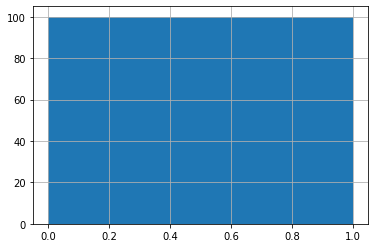

In [22]:
labels_df[' hemorrhage'].hist(bins=2)

There is the same amount of data for both cases.

Images are not the same sizes! We need to find the optimal size, but before we have to explore it.

In [23]:
images_df = pd.DataFrame(images, columns=['image'])

In [24]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffe540ffc50>,
      dtype=object)

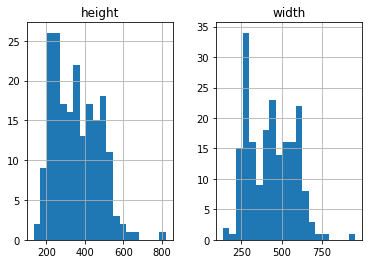

In [25]:
images_df[['height', 'width']].hist(bins=20)

In [26]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


Before we will create and train model, we need to make all images the same sizes.

The tradeoff is simple here - lesser images would be faster to train, there would be a lot of examples so lesser chance of overfitting, but it is a clear loss of information. If the error would be still big, we will need to consider to use a bigger size, and either stretch little images (and lose quality significantly) or drop them entirely (and risk overfitting).

For now we will go the simplest path - resizing to the smallest size (and even smaller - 128 insted of 134).

In [27]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

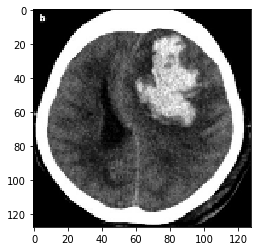

In [28]:
plt.imshow(images[0])

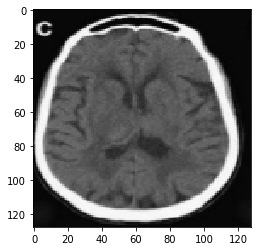

In [29]:
plt.imshow(images[100])

The quality of images seems to be acceptable.

# Adding flipped images

We could also improve the dataset by adding flipped images. It doesn't matter from what side we will look at the CT scan, brain hemorrhage can and should be diagnosed just as well. By adding flipped images to dataset, we can greatly increase the accuracy of model.

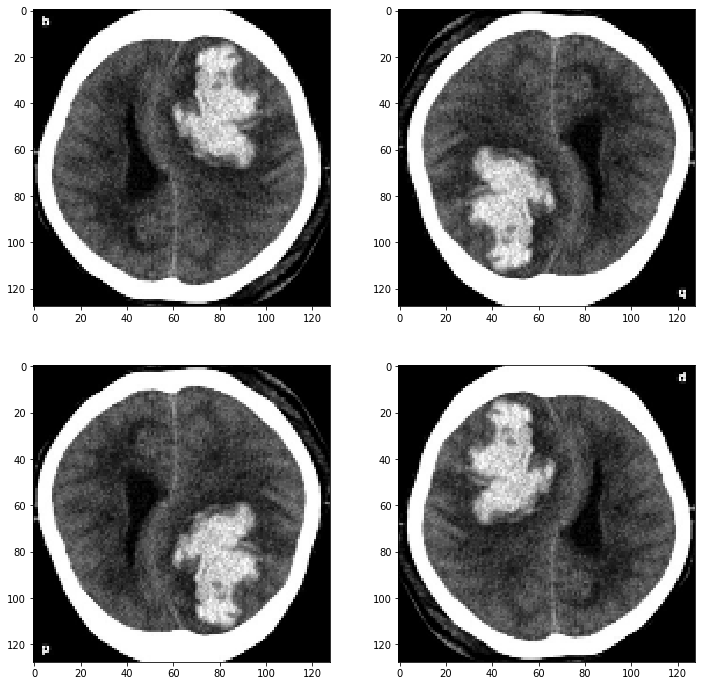

In [30]:
plt.figure(figsize=(12, 12))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))

Now, we don't want those flipped images in our test set just to be sure model didn't create any preferences for upside down and flipped images, so the dataset expansion should take place after split into train and test sets.

Fortunately, there is ImageDataGenerator for the purposes of flipping and rotating images.

Split data into train, validation and test subsets.

In [31]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
# since data is strictly true until index 100 and then strictly false,
# we can take random 90 entries from frist half and then random 90 from the second half
# to have evenly distributed train and test sets
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [33]:
# now to split train and validation sets
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


>Now it's times to get our hand dirty where we import the needed libraries to train the model 

In [34]:
import keras

Using TensorFlow backend.


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

# Image Segmentation & augmentation

In [36]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

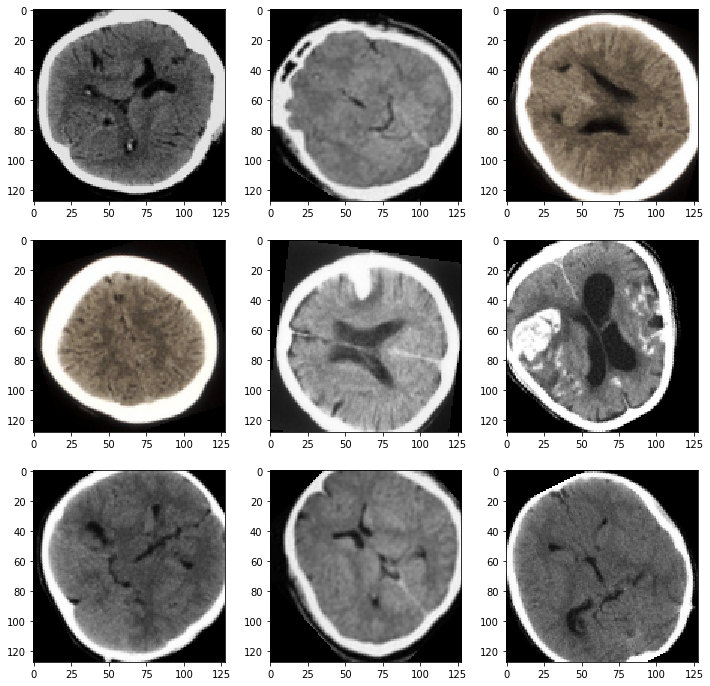

In [37]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

# Building the model

In [38]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title('pred %s actual %s' % (str(predicted[i]), str(actual[i])))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print('True positive: %s, True negative:  %s, False positive: %s, False negative: %s' % (tp, tn, fp, fn))

    print('Total accuracy:', np.sum(predicted==actual) / len(predicted) * 100., '%')
    return (tn, fp, fn, tp)

In [39]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [40]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

# Training model

In [42]:
model.fit_generator(train_image_data.flow(trainX, trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint('ct-brain-detection-checkpoint.h5', monitor='val_acc', save_best_only=True, mode='max')],
    epochs=16)

Epoch 1/16
128/128 [==============================] - 38s 298ms/step - loss: 0.6748 - accuracy: 0.5731 - val_loss: 0.3631 - val_accuracy: 0.8344
Epoch 2/16
  1/128 [..............................] - ETA: 12s - loss: 0.6432 - accuracy: 0.6172

/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


128/128 [==============================] - 39s 301ms/step - loss: 0.6220 - accuracy: 0.6549 - val_loss: 0.6357 - val_accuracy: 0.7078
Epoch 3/16
128/128 [==============================] - 39s 304ms/step - loss: 0.5826 - accuracy: 0.7009 - val_loss: 0.5880 - val_accuracy: 0.7278
Epoch 4/16
128/128 [==============================] - 40s 314ms/step - loss: 0.5513 - accuracy: 0.7188 - val_loss: 0.9760 - val_accuracy: 0.6922
Epoch 5/16
128/128 [==============================] - 40s 310ms/step - loss: 0.5276 - accuracy: 0.7405 - val_loss: 0.5483 - val_accuracy: 0.6422
Epoch 6/16
128/128 [==============================] - 40s 314ms/step - loss: 0.4860 - accuracy: 0.7709 - val_loss: 0.1011 - val_accuracy: 0.7244
Epoch 7/16
128/128 [==============================] - 40s 312ms/step - loss: 0.4563 - accuracy: 0.8004 - val_loss: 0.9478 - val_accuracy: 0.7256
Epoch 8/16
128/128 [==============================] - 42s 325ms/step - loss: 0.4087 - accuracy: 0.8206 - val_loss: 0.2444 - val_accuracy: 0.7

True positive: 8, True negative:  8, False positive: 0, False negative: 2
Total accuracy: 88.88888888888889 %


(8, 0, 2, 8)

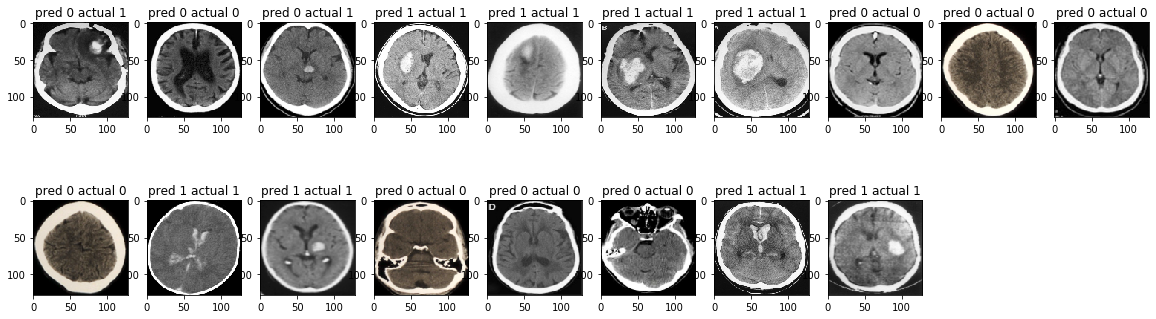

In [43]:
check_accuracy(model, validationX/255., validationY)

In [45]:
model.save('ct-brain-detection_last-weights.h5')
model.load_weights('ct-brain-detection_last-weights.h5')

In [46]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 75, True negative:  77, False positive: 5, False negative: 5
Total accuracy: 93.82716049382715 %


(77, 5, 5, 75)

True positive: 8, True negative:  8, False positive: 0, False negative: 2
Total accuracy: 88.88888888888889 %


(8, 0, 2, 8)

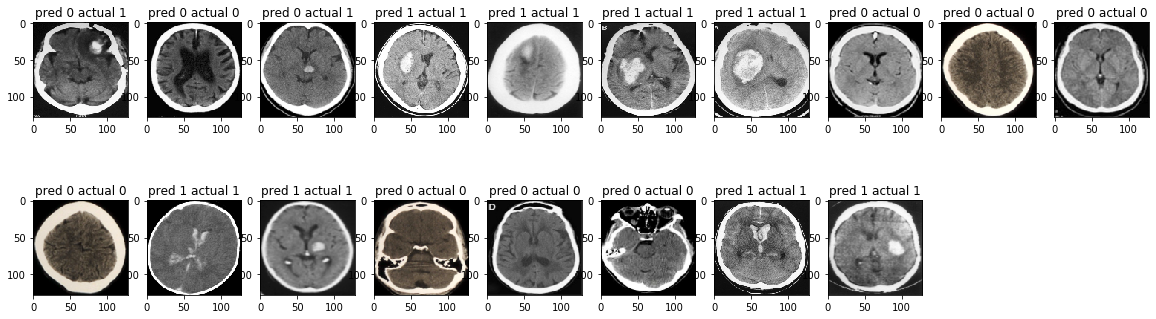

In [47]:
check_accuracy(model, validationX/255., validationY)

The overall generalization of model seems good, overfitting isn't too big. But since this is a medical problem, we have to consider one additional thing.

# False negative result will kill patient
False positive result will be an inconvinience.

We have to punish false negative results while training the model.

Punishing false negatives may be implemented in several ways.
* imbalance dataset so there are more positive cases, therefore model will prefer false positives over false negatives
* make it a multiclass classification and use 'class_weight' parameter of Keras (which is essentially will do the same trick)
* write custom loss function that is oriented on lowering false negativer rate (or improving _sensitivity_)
* or write custom metrics, based on which checkpoint will save model

Let's try the approach with imbalancing training dataset.

In [48]:
def imbalance_set(coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        def add_entry(x, y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)

        add_entry(train_x, trainY[i])

        if(trainY[i] == 1):
            for j in range(coeff-1):
                add_entry(train_x, trainY[i])
    return (np.array(imbalanced_trainX), np.array(imbalanced_trainY))

imbalanced_trainX, imbalanced_trainY = imbalance_set(2)
print(imbalanced_trainX.shape, imbalanced_trainY.shape)

(242, 128, 128, 3) (242,)


In [49]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [50]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [51]:
model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint('bigger_model_checkpoint_weights.h5', monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)

Epoch 1/24
128/128 [==============================] - 56s 436ms/step - loss: 0.6119 - accuracy: 0.6686 - val_loss: 0.4061 - val_accuracy: 0.8456
Epoch 2/24
128/128 [==============================] - 58s 454ms/step - loss: 0.5612 - accuracy: 0.7200 - val_loss: 1.1188 - val_accuracy: 0.8267
Epoch 3/24
128/128 [==============================] - 58s 451ms/step - loss: 0.5274 - accuracy: 0.7436 - val_loss: 0.3996 - val_accuracy: 0.8544
Epoch 4/24
128/128 [==============================] - 58s 450ms/step - loss: 0.4950 - accuracy: 0.7647 - val_loss: 0.3747 - val_accuracy: 0.8000
Epoch 5/24
128/128 [==============================] - 57s 446ms/step - loss: 0.4569 - accuracy: 0.7931 - val_loss: 0.9430 - val_accuracy: 0.8311
Epoch 6/24
128/128 [==============================] - 57s 444ms/step - loss: 0.4119 - accuracy: 0.8180 - val_loss: 0.2208 - val_accuracy: 0.8333
Epoch 7/24
128/128 [==============================] - 57s 449ms/step - loss: 0.3704 - accuracy: 0.8436 - val_loss: 1.0226 - val_ac

In [52]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 80, True negative:  77, False positive: 5, False negative: 0
Total accuracy: 96.91358024691358 %


(77, 5, 0, 80)

In [53]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 9, True negative:  7, False positive: 1, False negative: 1
Total accuracy: 88.88888888888889 %


(7, 1, 1, 9)

In [55]:
model.save('bigger_model_latest_weights.h5')
model.load_weights('bigger_model_latest_weights.h5')

In [56]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 80, True negative:  77, False positive: 5, False negative: 0
Total accuracy: 96.91358024691358 %


(77, 5, 0, 80)

In [57]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 9, True negative:  7, False positive: 1, False negative: 1
Total accuracy: 88.88888888888889 %


(7, 1, 1, 9)

# 89% of accuracy on validation set and 0 false negative
Time to check model on test set

True positive: 8, True negative:  7, False positive: 3, False negative: 2
Total accuracy: 75.0 %


(7, 3, 2, 8)

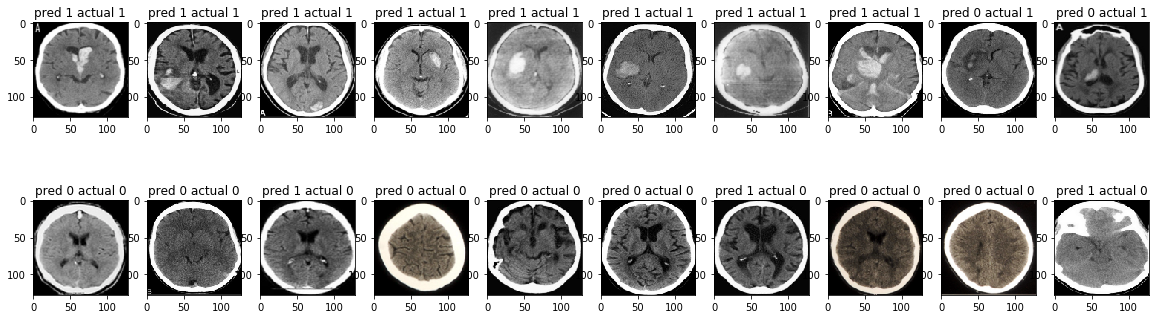

In [58]:
check_accuracy(model, testX/255., testY)

Model showed good results.

Additional improvements could be made if image augmentation contained alterations of contrast.